# The Box-Muller Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats

%matplotlib inline

In [2]:
plt.rc("figure", figsize=(15,5), dpi=100)

### Algorithm

Inputs:
$$
u_0 \sim \mathcal{U} \\
u_1 \sim \mathcal{U}
$$

Processing steps:

$$
e = -2\ln(u_0) \\
f = \sqrt{e} \\
g_0 = \sin(2\pi u_1) \\
g_1 = \cos(2\pi u_1) \\
x_0 = f \times g_0 \\
x_1 = f \times g_1
$$

In [3]:
def split_range(xmin, xmax, sections):
    length = xmax - xmin
    section_length = length / sections
    
    return [(xmin + i * section_length, xmin + (i+1) * section_length) for i in range(sections)]

In [4]:
def build_approximation_tables(f, xmin, xmax, degree=1, sections=128):
    return np.array([np.polyfit(np.linspace(0, 1, 1024), f(np.linspace(smin, smax, 1024)), degree) for smin, smax in split_range(xmin, xmax, sections)])

In [5]:
def approximate_from_table(table, xmin, xmax, x):
    return np.sum(np.power(np.fmod(x-xmin, (xmax-xmin)/table.shape[0])[:,np.newaxis] * table.shape[0] / (xmax-xmin), (table.shape[1]-1-np.arange(table.shape[1]))[np.newaxis,:]) * table[((x-xmin)/(xmax-xmin)*table.shape[0]).astype(int)], axis=1)

In [6]:
# f = lambda x: np.sin(1/2 * np.pi * x)
f = lambda x: np.log(x)

In [7]:
log_table = build_approximation_tables(np.log, 1, 2, degree=2, sections=256)

sqrt_table_0 = build_approximation_tables(lambda x: np.sqrt(x) - 1, 1, 2, sections=64, degree=1)
sqrt_table_1 = build_approximation_tables(lambda x: np.sqrt(x) - 1, 2, 4, sections=64, degree=1)

sin_table = build_approximation_tables(lambda x: np.sin(np.pi/2 * x), 0, 1, sections=128, degree=1)
cos_table = build_approximation_tables(lambda x: np.cos(np.pi/2 * x), 0, 1, sections=128, degree=1)

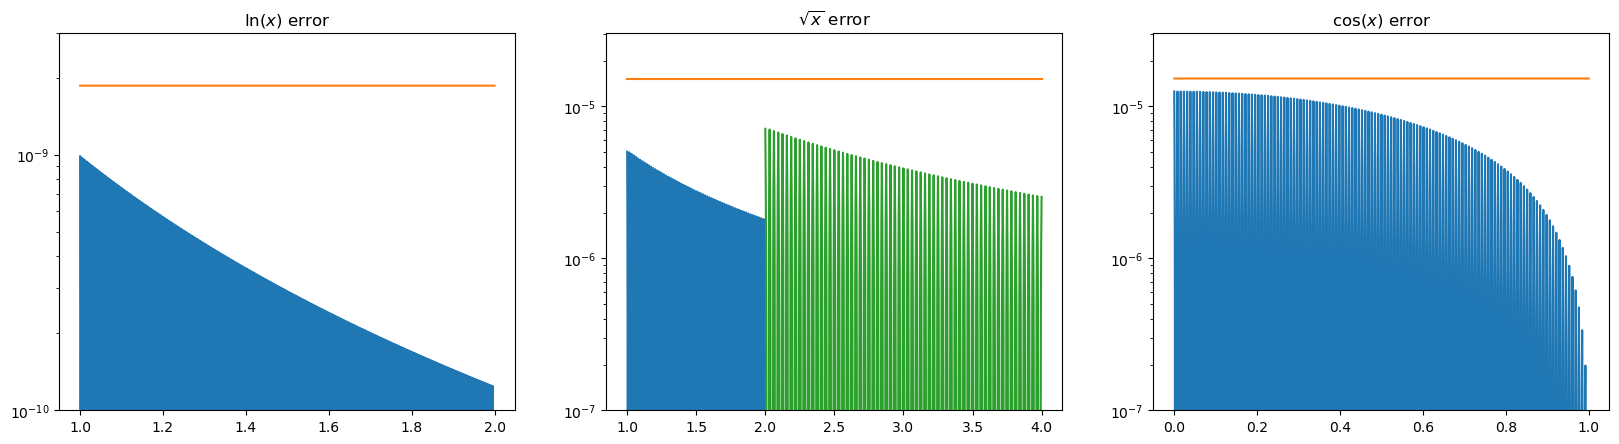

In [8]:
plt.figure(figsize=(20, 5))

error_floor = 2**-16

plt.subplot(1, 3, 1)
plt.title("$\\ln(x)$ error")
x = np.linspace(1, 2, 8192, endpoint=False)
plt.plot(x, np.abs(approximate_from_table(log_table, 1, 2, x)) - f(x))
plt.plot(x, np.ones_like(x) * 2**-29)
plt.yscale("log")
plt.ylim((1e-10, 3e-9));

plt.subplot(1, 3, 2)
plt.title("$\\sqrt{x}$ error")
x = np.linspace(1, 2, 8192 * 8, endpoint=False)
plt.plot(x, np.abs(approximate_from_table(sqrt_table_0, 1, 2, x)) - np.sqrt(x) + 1)
plt.plot(np.linspace(1, 4, 2), np.ones(2) * error_floor)
x = np.linspace(2, 4, 8192 * 8, endpoint=False)
plt.plot(x, np.abs(approximate_from_table(sqrt_table_1, 2, 4, x)) - np.sqrt(x) + 1)
plt.yscale("log")
plt.ylim(1e-7, 2*error_floor);

plt.subplot(1, 3, 3)
plt.title("$\\cos(x)$ error")
x = np.linspace(0, 1, 8192, endpoint=False)
plt.plot(x, np.abs(approximate_from_table(cos_table, 0, 1, x)) - np.cos(x * np.pi/2))
plt.plot(x, np.ones_like(x) * error_floor)
plt.yscale("log")
plt.ylim(1e-7, 2*error_floor);

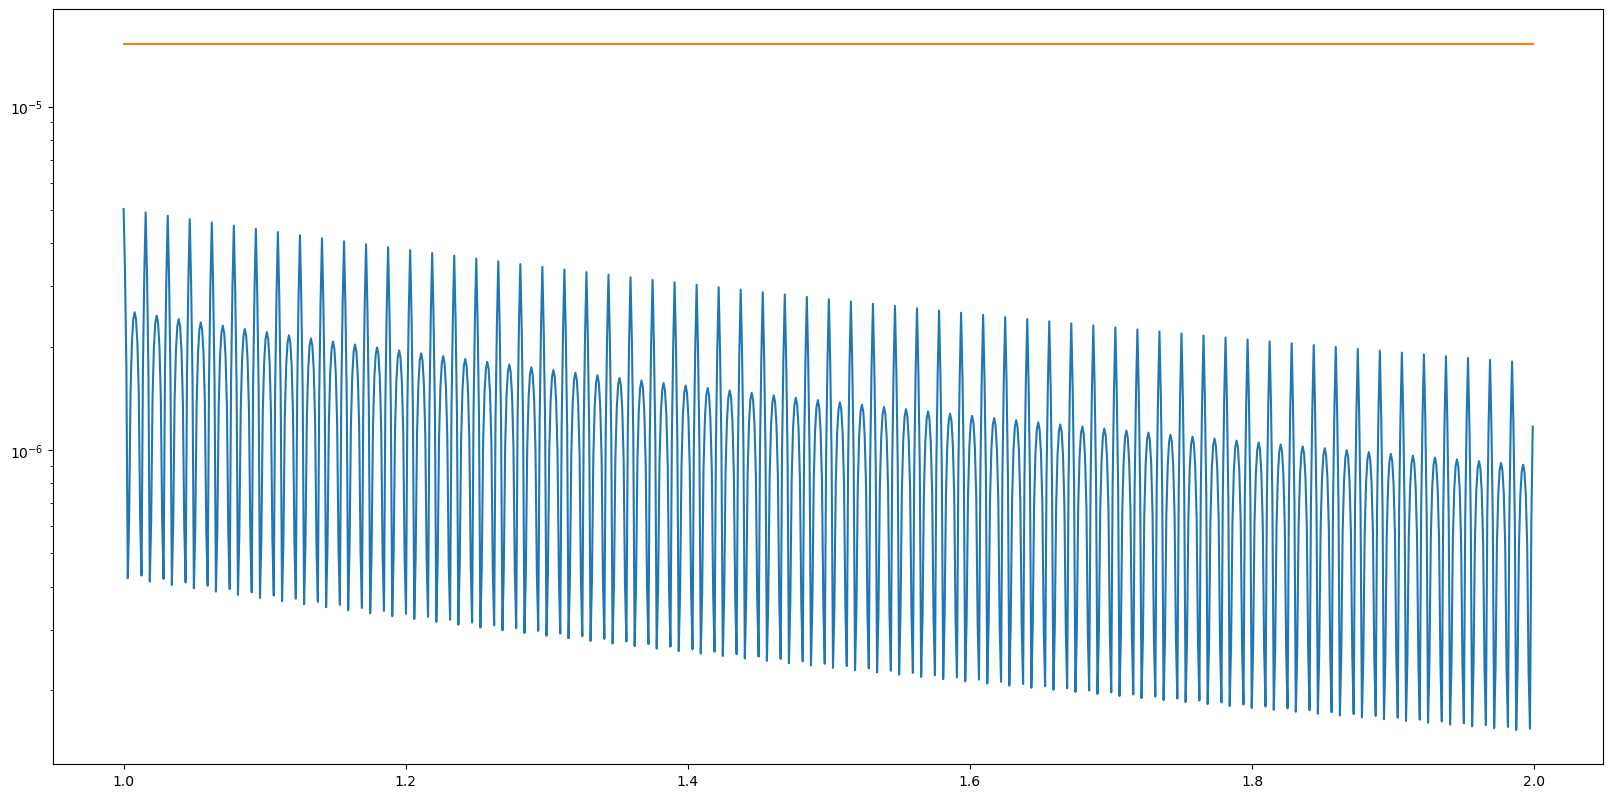

In [9]:
x = np.linspace(1, 2, 1024, endpoint=False)

plt.figure(figsize=(20, 10))
plt.plot(x, np.abs(approximate_from_table(sqrt_table_0, 1, 2, x) - np.sqrt(x) + 1))
plt.plot(x, np.ones_like(x) * 2**-16)
plt.yscale("log")
# plt.ylim((10**-10, 1))

In [10]:
(log_table * 2**30).astype(int)[:,::-1].flatten()[0::3] / 2**30;

In [11]:
def build_format_string(widths):
    s = ""
    for width in widths:
        s = s + "{:0" + str(width) + "b}"
    return s

In [12]:
def format_binary_string(din, length):
    return ("{:0" + str(length) + "b}").format(din)

In [31]:
def gen_rom(table, power, widths, signmod):
    fxpnt_table = (table * 2**power * signmod).astype(int)
    fmt = build_format_string(widths)
    # fmt.format(x[0] & ((2**widths[0])-1), x[1] & ((2**widths[1])-1), x[2] & ((2**widths[2])-1))
    return ["".join([format_binary_string(s & ((2**widths[i])-1), widths[i]) for i,s in enumerate(x)]) for x in fxpnt_table]

In [45]:
def gen_rom_c(table, power, widths, signmod):
    fxpnt_table = (table * 2**power * signmod).astype(int)
    fmt = build_format_string(widths)
    # fmt.format(x[0] & ((2**widths[0])-1), x[1] & ((2**widths[1])-1), x[2] & ((2**widths[2])-1))
    return [[hex(s & ((2**widths[i])-1)) for i,s in enumerate(x)] for x in fxpnt_table]

In [46]:
def print_rom(rom, tabs=2):
    print(repr(rom).replace("'", '"'))

In [47]:
log_rom = gen_rom(log_table, 30, np.array([14, 23, 31]), np.array([1, 1, 1]))

In [64]:
gen_rom_c(log_table, 30, np.array([14, 23, 31]), np.array([1, 1, 1]))

[['0x2020', '0x3ffff3', '0x1'],
 ['0x2060', '0x3fc033', '0x3fe016'],
 ['0x209e', '0x3f80f1', '0x7f80aa'],
 ['0x20dc', '0x3f422d', '0xbee23c'],
 ['0x2119', '0x3f03e4', '0xfe0546'],
 ['0x2155', '0x3ec615', '0x13cea45'],
 ['0x2191', '0x3e88bf', '0x17b91b1'],
 ['0x21cc', '0x3e4be0', '0x1b9fc03'],
 ['0x2207', '0x3e0f78', '0x1f829b1'],
 ['0x2240', '0x3dd384', '0x2361b32'],
 ['0x2279', '0x3d9804', '0x273d0f8'],
 ['0x22b2', '0x3d5cf5', '0x2b14b76'],
 ['0x22e9', '0x3d2258', '0x2ee8b1f'],
 ['0x2321', '0x3ce82a', '0x32b9062'],
 ['0x2357', '0x3cae6a', '0x3685baf'],
 ['0x238d', '0x3c7518', '0x3a4ed72'],
 ['0x23c3', '0x3c3c31', '0x3e14618'],
 ['0x23f7', '0x3c03b5', '0x41d660e'],
 ['0x242b', '0x3bcba3', '0x4594dbc'],
 ['0x245f', '0x3b93f9', '0x494fd8c'],
 ['0x2492', '0x3b5cb6', '0x4d075e6'],
 ['0x24c5', '0x3b25da', '0x50bb730'],
 ['0x24f7', '0x3aef62', '0x546c1d0'],
 ['0x2528', '0x3ab94f', '0x581962b'],
 ['0x2559', '0x3a839e', '0x5bc34a3'],
 ['0x2589', '0x3a4e4f', '0x5f69d9c'],
 ['0x25b9', '0x3a1961'

In [50]:
# print_rom(log_rom)

In [17]:
sqrt_rom_0 = gen_rom(sqrt_table_0, 18, np.array([13, 19]), np.array([1,1]))
sqrt_rom_1 = gen_rom(sqrt_table_1, 18, np.array([13, 19]), np.array([1,1]))

sqrt_rom = sqrt_rom_0 + sqrt_rom_1

In [58]:
sqrt_table_1.shape

(64, 2)

In [55]:
# print_rom(sqrt_rom)
gen_rom_c(np.concatenate((sqrt_table_0, sqrt_table_1)), 18, np.array([13, 19]), np.array([1,1]))

[['0x7f8', '0x1'],
 ['0x7e8', '0x7f9'],
 ['0x7d9', '0xfe1'],
 ['0x7ca', '0x17ba'],
 ['0x7bb', '0x1f85'],
 ['0x7ad', '0x2740'],
 ['0x79f', '0x2eed'],
 ['0x791', '0x368d'],
 ['0x784', '0x3e1e'],
 ['0x777', '0x45a2'],
 ['0x76a', '0x4d1a'],
 ['0x75d', '0x5484'],
 ['0x751', '0x5be1'],
 ['0x745', '0x6333'],
 ['0x739', '0x6a78'],
 ['0x72d', '0x71b1'],
 ['0x722', '0x78de'],
 ['0x716', '0x8000'],
 ['0x70b', '0x8717'],
 ['0x700', '0x8e23'],
 ['0x6f6', '0x9524'],
 ['0x6eb', '0x9c1a'],
 ['0x6e1', '0xa306'],
 ['0x6d7', '0xa9e8'],
 ['0x6cd', '0xb0bf'],
 ['0x6c3', '0xb78d'],
 ['0x6ba', '0xbe51'],
 ['0x6b0', '0xc50b'],
 ['0x6a7', '0xcbbc'],
 ['0x69e', '0xd263'],
 ['0x695', '0xd902'],
 ['0x68c', '0xdf97'],
 ['0x683', '0xe624'],
 ['0x67b', '0xeca8'],
 ['0x672', '0xf323'],
 ['0x66a', '0xf996'],
 ['0x662', '0x10000'],
 ['0x65a', '0x10662'],
 ['0x652', '0x10cbd'],
 ['0x64a', '0x1130f'],
 ['0x642', '0x11959'],
 ['0x63b', '0x11f9c'],
 ['0x633', '0x125d7'],
 ['0x62c', '0x12c0b'],
 ['0x624', '0x13237'],
 ['0x6

In [18]:
(sqrt_table_1[0x4f-64] * 2**18).astype(int)

array([  2598, 149744])

In [38]:
# print_rom(sqrt_rom)

In [20]:
(sin_table[int(0.6231689453125 * 128)] * 2**17).astype(int)

array([   901, 108081])

In [21]:
sin_rom = gen_rom(sin_table, 17, np.array([12, 19]), np.ones(2))
cos_rom = gen_rom(cos_table, 17, np.array([12, 19]), np.ones(2))

In [59]:
# print_rom(np.core.defchararray.add(np.array(sin_rom), np.array(cos_rom)))

In [68]:
cos_table.shape

(128, 2)

In [67]:
gen_rom_c(np.concatenate((sin_table, cos_table), axis=1), 17, np.array([12, 19, 12, 19]), np.ones(4))

[['0x648', '0x0', '0xff7', '0x20001'],
 ['0x648', '0x648', '0xfe3', '0x1fff7'],
 ['0x647', '0xc90', '0xfcf', '0x1ffda'],
 ['0x647', '0x12d8', '0xfbb', '0x1ffa8'],
 ['0x646', '0x191f', '0xfa8', '0x1ff63'],
 ['0x644', '0x1f65', '0xf94', '0x1ff0a'],
 ['0x643', '0x25aa', '0xf80', '0x1fe9e'],
 ['0x641', '0x2bed', '0xf6d', '0x1fe1e'],
 ['0x63f', '0x322f', '0xf59', '0x1fd8a'],
 ['0x63d', '0x386f', '0xf45', '0x1fce3'],
 ['0x63b', '0x3eac', '0xf32', '0x1fc27'],
 ['0x638', '0x44e7', '0xf1e', '0x1fb59'],
 ['0x635', '0x4b20', '0xf0b', '0x1fa76'],
 ['0x632', '0x5156', '0xef7', '0x1f981'],
 ['0x62f', '0x5788', '0xee4', '0x1f877'],
 ['0x62b', '0x5db7', '0xed0', '0x1f75b'],
 ['0x627', '0x63e3', '0xebd', '0x1f62b'],
 ['0x623', '0x6a0a', '0xeaa', '0x1f4e7'],
 ['0x61f', '0x702e', '0xe96', '0x1f390'],
 ['0x61a', '0x764d', '0xe83', '0x1f226'],
 ['0x615', '0x7c68', '0xe70', '0x1f0a9'],
 ['0x610', '0x827e', '0xe5d', '0x1ef19'],
 ['0x60b', '0x888f', '0xe4a', '0x1ed75'],
 ['0x606', '0x8e9a', '0xe37', '0x1ebbf'

In [23]:
cos_rom[0][12:]

'0100000000000000001'

# Some integer arithmetic

## Elemental Functions

### The fixed point natural logarithm

Let $x$ be a real number in fixed point representation, with $IB_x$ integer bits, and $FB_x$ fraction bits.

Then $x$ can be written as $2^E * M$, where $M \in [1,2)$, and $E \in \{(-FB_x) ... (IB_x-1)\}$

The natural logarithm of $x$, $\ln{x}$, can then be reduced to the following problem:
$\ln{x} = \ln{(2^E * M)} = \ln{2^E} + \ln{M} = E * \ln{2} + \ln{M}$.

E can be determined by counting the leading zeros of $x$.

Let $IB_X = FB_x = 4$, $x = 0101.0110$. Then $M = 1.010110$ and $E = 2 = IB_x - 1 - 1$. We can then put together $ln(x) = 2 * \ln(2) + \ln(M)$, where $M$ will be calculated using a piecewise polynomial.

Alternatively let $x = 0000.0110$. Then $M = 1.10$ and $E = -2 = IB_x - 1 - 5$.


In [24]:
2 * np.log(2) + np.log(int("1010110", 2) / 64)

1.6817585740137264

In [25]:
np.log(int("1010110", 2) / 16)

1.6817585740137264

# Verification

In [26]:
def lzd(x, l):
    return l-(len(bin(x))-2)

In [27]:
def gaussian(u_0, u_1, u_2):
    exp_e = lzd(u_0, 48) + 1
    e = 2 * (np.log(2) * exp_e - np.log(1+u_2*2**-31))
    
    f = np.sqrt(e)
    
    return (np.sin(2*np.pi*u_1*2**-16)*f, np.cos(2*np.pi*u_1*2**-16)*f)

In [28]:
gaussian(0xc63ef7f1ec5a, 0x6e43, 0x716be206)

(0.14442150852363367, -0.3104984098583701)